<a href="https://colab.research.google.com/github/vic-torr/thesis-experiments/blob/main/experiments/swin_forest_from_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Environment

In [1]:
import sys
RunningInCOLAB = 'google.colab' in sys.modules

if RunningInCOLAB:  
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    #!unzip /content/drive/MyDrive/Colab-Notebooks/datasets/planet.zip -d /content/drive/MyDrive/Colab-Notebooks/datasets/planet
    !unzip /content/drive/MyDrive/Colab-Notebooks/datasets/planet.zip -d /content/;
    dataset_dir="/content/planet/"
    #dataset_dir="/content/drive/MyDrive/Colab-Notebooks/datasets/planet/"
else:
    home = os.environ['HOME']
    dataset_dir= home+"/UFMG/Thesis/datasets/planet"

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Colab-Notebooks/datasets/planet.zip
replace /content/planet/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
if RunningInCOLAB:
    %pip install torch torchvision sklearn dill tqdm plotly matplotlib torchinfo virtualenv opencv-python transformers datasets evaluate timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np # Torch wrapper for Numpy
from PIL import Image
import os

import random
from time import time
from glob import glob
from tqdm.notebook import tqdm
from collections import Counter
import dill as pickle

from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
%matplotlib inline

import cv2

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, confusion_matrix

import torch
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary
import timm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


In [4]:

def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

In [5]:
!ls $dataset_dir

sample_submission.csv  test-jpg  train_classes.csv  train-jpg


# EDA

In [6]:
path = dataset_dir
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")
print(
    f"train files: {len(os.listdir(path_train))}, "
    f"test files: {len(os.listdir(path_test))}"
)

train files: 40479, test files: 40669


In [7]:
!ls -1 ~/UFMG/Thesis/datasets/planet/train-jpg | wc -l

ls: cannot access '/root/UFMG/Thesis/datasets/planet/train-jpg': No such file or directory
0


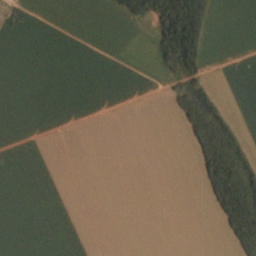

In [8]:
im = Image.open(path_train+'/train_32.jpg')
image_file = im.convert("RGB")
display(image_file)

In [9]:
path_class = os.path.join(path, "train_classes.csv")
df_class = pd.read_csv(path_class)
print(df_class.shape)
df_class.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
df_class["list_tags"] = df_class.tags.str.split(" ")
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")

fig = px.bar(df_tags, x="total", y="tag", orientation="h", 
             color="total",
)
fig.update_layout(title="Class distribution")
fig.show()

In [11]:
RARE_CLASSES = [
    "bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"
]

In [12]:
df_train, df_val = train_test_split(df_class, test_size=.2)

for rare_class in RARE_CLASSES:
    total_train = df_train.loc[df_train.tags.str.contains(rare_class)].shape[0]
    total_val = df_val.loc[df_val.tags.str.contains(rare_class)].shape[0]
    print(f"train {rare_class}: {100 * total_train / df_train.shape[0]:.4f}% ({total_train})")
    print(f"val {rare_class}: {100 * total_val / df_val.shape[0]:.4f}% ({total_val})\n")

train bare_ground: 2.1431% (694)
val bare_ground: 2.0751% (168)

train selective_logging: 0.8399% (272)
val selective_logging: 0.8399% (68)

train artisinal_mine: 0.8152% (264)
val artisinal_mine: 0.9264% (75)

train blooming: 0.8461% (274)
val blooming: 0.7164% (58)

train slash_burn: 0.5373% (174)
val slash_burn: 0.4323% (35)

train blow_down: 0.2501% (81)
val blow_down: 0.2100% (17)

train conventional_mine: 0.2378% (77)
val conventional_mine: 0.2841% (23)



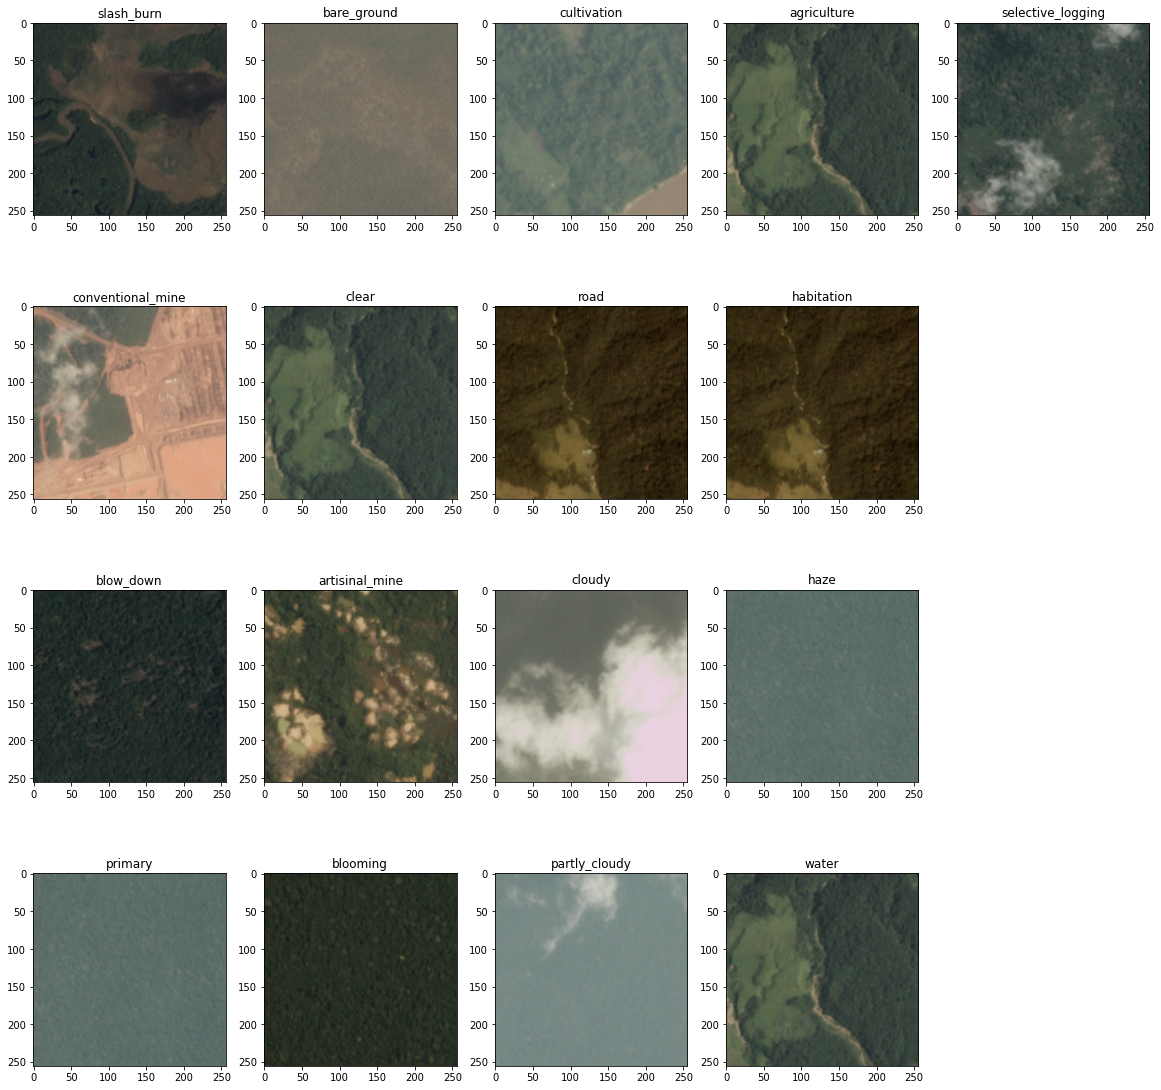

In [13]:
all_tags = list(set(tags))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()

In [14]:
def load_img(path_file):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype(float)
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    return img

In [15]:
filenames = df_class.image_name.sample(600).values
path_files = [os.path.join(path_train, filename+".jpg") for filename in filenames]
X_train_sample = np.vstack([load_img(path_file) for path_file in path_files])
X_train_sample.shape

(600, 30000)

In [16]:
def fetch_img(path_file, h, w):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (h*2, w*2), cv2.INTER_LINEAR)
    return img

In [17]:
def tsne_analysis():

    tsne = TSNE(
        n_components=2,
        init="random",
        random_state=101,
        method="barnes_hut",
        n_iter=500,
        verbose=2,
    )
    X_embedded = tsne.fit_transform(X_train_sample)
    X_embedded.shape

    size_img = 1000
    offset_img = 50
    h = w = int(offset_img / 2)

    X_scaled = (X_embedded - X_embedded.min(0)) / (X_embedded.max(0) - X_embedded.min(0))
    X_scaled = (X_scaled * size_img).astype(int)
    X_scaled = np.clip(X_scaled, offset_img, size_img-offset_img)

    img_tsne = np.ones((size_img+2*offset_img, size_img+2*offset_img, 3), dtype=np.uint8) * 255
    for idx in range(X_scaled.shape[0]):
        x, y = X_scaled[idx][0], X_scaled[idx][1]
        img = fetch_img(path_files[idx], h, w)
        img_tsne[x-w:x+w, y-h:y+h, :] = img

    fig = plt.figure(figsize=(12, 12))
    plt.imshow(img_tsne);
    plt.axis("off");
#tsne_analysis()    

# Config

In [18]:
BATCH_SIZE = 2
if RunningInCOLAB:
    BATCH_SIZE = 32
IMG_SIZE = 224
LR = 1e-4
LR_STEP_SIZE = 7
GAMMA = 0.1
N_EPOCHS = 14

# Dataset prep

In [19]:

def transform1(img):
    return T.Compose([
      T.ToTensor(),
      F.interpolate(img, size=224, mode='bicubic'),
      T.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225],
      )
    ])
    
# create image augmentations
transform_train = transforms.Compose(
    [
        #transforms.Resize((IMG_SIZE, IMG_SIZE),interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
      T.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225],
      )
    ]
)

transform_val = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE),interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
      T.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225],
      )
    ]
)

#    return transform_train, transform_val



In [20]:
class AmazonDatasetError(Exception):
    pass


class AmazonDataset(Dataset):
    def __init__(self, df, ohe_tags, transform, path, is_train=True, idx_tta=None):
        super().__init__()
        self.df = df
        self.ohe_tags = ohe_tags
        self.transform = transform_train
        if isinstance(path, str):
            self.paths = [path]
        elif isinstance(path, (list, tuple)):
            self.paths = path
        else:
            raise AmazonDatasetError(f"Path type must be str, list or tuple, got: {type(path)}")
        self.is_train = is_train
        if not is_train:
            if not idx_tta in list(range(6)):
                raise AmazonDatasetError(
                    f"In test mode, 'idx_tta' must be an int belonging to [0, 5], got: {repr(idx_tta)}"
                )
            self.idx_tta = idx_tta

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        for path in self.paths:
            if filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                break
        else:
            raise AmazonDatasetError(f"Can't fetch {filename} among {self.paths}")
        #image = cv2.imread(file_path)
        #image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = Image.open(file_path).convert("RGB")
        label = self.ohe_tags[idx]
        return image, label

    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
            img = self.transform(img)
            img.permute(2, 0, 1)
            imgs.append(img[None])
            labels.append(label)
        imgs = torch.cat(imgs).float().to(device)
        labels = torch.tensor(labels).float().to(device)
        return imgs, labels

    def load_img(self, idx, ax=None):
        img, ohe_label = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {ohe_label} - {self.transform(img).shape}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)
        
    


In [21]:
def get_data(df_train, df_val):

    encoder = MultiLabelBinarizer()
    ohe_tags_train = encoder.fit_transform(df_train.list_tags.values)
    ohe_tags_val = encoder.transform(df_val.list_tags.values)

    ds_train = AmazonDataset(df_train, ohe_tags_train, transform_train, path=path_train)
    ds_val = AmazonDataset(df_val, ohe_tags_val, transform_val, path=path_train)

    dl_train = DataLoader(
      ds_train,
      batch_size=BATCH_SIZE,
      shuffle=True,
      collate_fn=ds_train.collate_fn
    )
    dl_val = DataLoader(
      ds_val,
      batch_size=BATCH_SIZE,
      shuffle=True,
      collate_fn=ds_val.collate_fn
    )

    return ds_train, ds_val, dl_train, dl_val, encoder

In [22]:
ds_train, ds_val, dl_train, dl_val, encoder = get_data(df_train, df_val)

imgs, labels = next(iter(dl_train))
imgs.shape, labels.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)



(torch.Size([32, 3, 224, 224]), torch.Size([32, 17]))

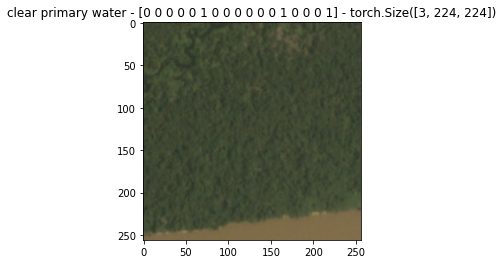

In [23]:
ds_train.load_img(5)

# Model

In [24]:
print("Available SWIN Models: ")
#timm.list_models("swin*")

Available SWIN Models: 


In [25]:
model = models.swin_transformer.swin_t(weights='IMAGENET1K_V1')
#model = models.swin_transformer.swin_t()
num_classes=17
swin_embed_dim = 768
for param in model.parameters():
    param.require_grad = False
model.head = nn.Linear(swin_embed_dim, num_classes) # assuming that the head layer has 768 neurons, otherwise change it     
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
loss_fn = nn.BCELoss() # Binary Cross Entropy
model = model.to(device)


In [26]:
#model.state_dict().keys()

In [27]:
state_dict = model.state_dict()

# delete relative_position_index since we always re-init it
relative_position_index_keys = [k for k in state_dict.keys() if "relative_position_index" in k]
for k in relative_position_index_keys:
    #print(f"del {state_dict[k]}")
    del state_dict[k]

# delete relative_coords_table since we always re-init it
relative_coords_table_keys = [k for k in state_dict.keys() if "relative_coords_table" in k]
for k in relative_coords_table_keys:
    print(f"del {state_dict[k]}")
    del state_dict[k]

# delete attn_mask since we always re-init it
attn_mask_keys = [k for k in state_dict.keys() if "attn_mask" in k]
for k in attn_mask_keys:
    print(f"del {state_dict[k]}")
    del state_dict[k]

torch.nn.init.constant_(model.head.bias, 0.)
torch.nn.init.constant_(model.head.weight, 0.)
del state_dict['head.weight']
del state_dict['head.bias']
info = model.load_state_dict(state_dict, strict=False)
print(info)
torch.cuda.empty_cache()

_IncompatibleKeys(missing_keys=['features.1.0.attn.relative_position_index', 'features.1.1.attn.relative_position_index', 'features.3.0.attn.relative_position_index', 'features.3.1.attn.relative_position_index', 'features.5.0.attn.relative_position_index', 'features.5.1.attn.relative_position_index', 'features.5.2.attn.relative_position_index', 'features.5.3.attn.relative_position_index', 'features.5.4.attn.relative_position_index', 'features.5.5.attn.relative_position_index', 'features.7.0.attn.relative_position_index', 'features.7.1.attn.relative_position_index', 'head.weight', 'head.bias'], unexpected_keys=[])


In [28]:
imgs, labels = next(iter(dl_train))
imgs.shape, labels.shape
model(imgs)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

from timm.utils import accuracy, AverageMeter
import sys
@torch.no_grad()
def validate(data_loader, model):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()

    batch_time = AverageMeter()
    loss_meter = AverageMeter()
    acc1_meter = AverageMeter()
    acc5_meter = AverageMeter()

    end = time()
    for idx, (images, target) in enumerate(data_loader):
        #images = images.cuda(non_blocking=True)
        #target = target.cuda(non_blocking=True)
        images
        # compute output
        output = model(images)
        print(output.size())
        # measure accuracy and record loss
        loss = criterion(output, target)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))

        loss_meter.update(loss.item(), target.size(0))
        acc1_meter.update(acc1.item(), target.size(0))
        acc5_meter.update(acc5.item(), target.size(0))

        # measure elapsed time
        batch_time.update(time() - end)
        end = time()


    memory_used = torch.cpu.max_memory_allocated() / (1024.0 * 1024.0)
    print(
        f'Test: [{idx}/{len(data_loader)}]\t'+
        f'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'+
        f'Loss {loss_meter.val:.4f} ({loss_meter.avg:.4f})\t'+
        f'Acc@1 {acc1_meter.val:.3f} ({acc1_meter.avg:.3f})\t'+
        f'Acc@5 {acc5_meter.val:.3f} ({acc5_meter.avg:.3f})\t'+
        f'Mem {memory_used:.0f}MB')
    print(f' * Acc@1 {acc1_meter.avg:.3f} Acc@5 {acc5_meter.avg:.3f}')
    return acc1_meter.avg, acc5_meter.avg, loss_meter.avg

validate(dl_train, model)    

In [29]:
[module for module in model.modules() if not isinstance(module, nn.Sequential)]

[SwinTransformer(
   (features): Sequential(
     (0): Sequential(
       (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
       (1): Permute()
       (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
     )
     (1): Sequential(
       (0): SwinTransformerBlock(
         (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
         (attn): ShiftedWindowAttention(
           (qkv): Linear(in_features=96, out_features=288, bias=True)
           (proj): Linear(in_features=96, out_features=96, bias=True)
         )
         (stochastic_depth): StochasticDepth(p=0.0, mode=row)
         (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
         (mlp): MLP(
           (0): Linear(in_features=96, out_features=384, bias=True)
           (1): GELU(approximate=none)
           (2): Dropout(p=0.0, inplace=False)
           (3): Linear(in_features=384, out_features=96, bias=True)
           (4): Dropout(p=0.0, inplace=False)
         )
       )
       (1): SwinTr

# Train setup

In [30]:
sample_X = None
def train_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    sample_X = X
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()


@torch.no_grad()
def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()

In [32]:
def train_model(dl_train, dl_val, idx_fold, model):
    optimizer = Adam(model.parameters(), lr=LR)
    loss_fn = nn.BCELoss()
    lr_scheduler = StepLR(optimizer, step_size=LR_STEP_SIZE, gamma=GAMMA)

    loss_train, loss_val = [], []
    score_train, score_val = [], []

    Y_hat_val = None
    best_loss_val = np.inf

    epochs = N_EPOCHS
    for idx in range(epochs):
        loss_train_epoch, loss_val_epoch = [], []
        Y_hat_train_epoch, Y_hat_val_epoch = [], []
        Y_train_epoch, Y_val_epoch = [], []

        for X, Y in tqdm(dl_train, leave=False):
            Y_hat, batch_loss = train_batch(X, Y, model, loss_fn, optimizer)
            loss_train_epoch.append(batch_loss)
            Y_hat_train_epoch.extend(Y_hat)
            Y_train_epoch.extend(Y.detach().float().cpu().numpy())

        for X, Y in tqdm(dl_val, leave=False):
            Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
            loss_val_epoch.append(batch_loss)
            Y_hat_val_epoch.extend(Y_hat)
            Y_val_epoch.extend(Y.detach().float().cpu().numpy())
                
        avg_loss_train = np.mean(loss_train_epoch)
        avg_loss_val = np.mean(loss_val_epoch)

        Y_hat_train_epoch = np.array(Y_hat_train_epoch)
        Y_hat_val_epoch = np.array(Y_hat_val_epoch)
        Y_thresh_train_epoch = (Y_hat_train_epoch > .2).astype(float)
        Y_thresh_val_epoch = (Y_hat_val_epoch > .2).astype(float)
        Y_train_epoch = np.array(Y_train_epoch)
        Y_val_epoch = np.array(Y_val_epoch)
        
        score_train_epoch = fbeta_score(Y_train_epoch, Y_thresh_train_epoch, beta=2, average="samples")
        score_val_epoch = fbeta_score(Y_val_epoch, Y_thresh_val_epoch, beta=2, average="samples")
                
        # saving values for debugging
        if avg_loss_val < best_loss_val:
            best_loss_val = avg_loss_val
            Y_hat_val = Y_hat_val_epoch
            Y_thresh_val = Y_thresh_val_epoch
            Y_val = Y_val_epoch
            
        loss_train.append(avg_loss_train)
        loss_val.append(avg_loss_val)
        score_train.append(score_train_epoch)
        score_val.append(score_val_epoch)

        print(
            f"epoch: {idx}/{epochs} -- train loss: {avg_loss_train}, " \
            f"val loss: {avg_loss_val}" \
            f" -- train fbeta_score: {score_train_epoch}, " \
            f"val fbeta_score: {score_val_epoch}"
        )
        
        lr_scheduler.step()

    train_results = {
        "loss_train": loss_train,
        "loss_val": loss_val,
        "score_train": score_train,
        "score_val": score_val,
        "Y_hat_val": Y_hat_val,
        "Y_thresh_val": Y_thresh_val,
        "Y_val": Y_val,
    }
        
    torch.save(model, f"swin_t_fold{idx_fold}.pth")
    pickle.dump(train_results, open(f"train_results_fold{idx_fold}.pkl", "wb"))

train_model(dl_train, dl_val, 0, model)

  0%|          | 0/1012 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
def train_model(dl_train, dl_val, idx_fold, model):
    optimizer = AdamW(model.parameters(), lr=1e-4)
    loss_fn = nn.BCELoss()
    lr_scheduler = StepLR(optimizer, step_size=LR_STEP_SIZE, gamma=GAMMA)

    loss_train, loss_val = [], []
    score_train, score_val = [], []

    Y_hat_val = None
    best_loss_val = np.inf

    epochs = N_EPOCHS
    for idx in range(epochs):
        loss_train_epoch, loss_val_epoch = [], []
        Y_hat_train_epoch, Y_hat_val_epoch = [], []
        Y_train_epoch, Y_val_epoch = [], []

        for X, Y in tqdm(dl_train, leave=False):
            Y_hat, batch_loss = train_batch(X, Y, model, loss_fn, optimizer)
            loss_train_epoch.append(batch_loss)
            Y_hat_train_epoch.extend(Y_hat)
            Y_train_epoch.extend(Y.detach().float().cpu().numpy())

        for X, Y in tqdm(dl_val, leave=False):
            Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
            loss_val_epoch.append(batch_loss)
            Y_hat_val_epoch.extend(Y_hat)
            Y_val_epoch.extend(Y.detach().float().cpu().numpy())
                
        avg_loss_train = np.mean(loss_train_epoch)
        avg_loss_val = np.mean(loss_val_epoch)

        Y_hat_train_epoch = np.array(Y_hat_train_epoch)
        Y_hat_val_epoch = np.array(Y_hat_val_epoch)
        Y_thresh_train_epoch = (Y_hat_train_epoch > .2).astype(float)
        Y_thresh_val_epoch = (Y_hat_val_epoch > .2).astype(float)
        Y_train_epoch = np.array(Y_train_epoch)
        Y_val_epoch = np.array(Y_val_epoch)
        
        score_train_epoch = fbeta_score(Y_train_epoch, Y_thresh_train_epoch, beta=2, average="samples")
        score_val_epoch = fbeta_score(Y_val_epoch, Y_thresh_val_epoch, beta=2, average="samples")
               
        # saving values for debugging
        if avg_loss_val < best_loss_val:
            best_loss_val = avg_loss_val
            Y_hat_val = Y_hat_val_epoch
            Y_thresh_val = Y_thresh_val_epoch
            Y_val = Y_val_epoch
            
        loss_train.append(avg_loss_train)
        loss_val.append(avg_loss_val)
        score_train.append(score_train_epoch)
        score_val.append(score_val_epoch)

        print(
            f"epoch: {idx}/{epochs} -- train loss: {avg_loss_train}, " \
            f"val loss: {avg_loss_val}" \
            f" -- train fbeta_score: {score_train_epoch}, " \
            f"val fbeta_score: {score_val_epoch}"
        )
        
        lr_scheduler.step()

    train_results = {
        "loss_train": loss_train,
        "loss_val": loss_val,
        "score_train": score_train,
        "score_val": score_val,
        "Y_hat_val": Y_hat_val,
        "Y_thresh_val": Y_thresh_val,
        "Y_val": Y_val,
    }
        
    torch.save(model, f"resnet18_fold{idx_fold}.pth")
    pickle.dump(train_results, open(f"train_results_fold{idx_fold}.pkl", "wb"))

In [ ]:
train_model(dl_train, dl_val, 0)

In [ ]:
%ls

In [ ]:
#model = torch.load("resnet18_fold0.pth")
#train_results = pickle.load(open("train_results_fold0.pkl", "rb"))

In [ ]:
oss_train = train_results["loss_train"]
loss_val = train_results["loss_val"]
score_train = train_results["score_train"]
score_val = train_results["score_val"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Fbeta scores"))
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_train))),
        y=loss_train,
        name="loss_train",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_val))),
        y=loss_val,
        name="loss_val",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_train))),
        y=score_train,
        name="score_train",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_val))),
        y=score_val,
        name="score_val",
    ),
    row=1, col=2
)
fig.show()

In [ ]:
Y_hat_val = np.array(train_results["Y_hat_val"])
Y_val = np.array(train_results["Y_val"])

pos_probas, neg_probas = [], []
for class_, idx in encoder._cached_dict.items():
    pos_probas.append(Y_hat_val[np.where(Y_val[:, idx] != 0), idx].mean())
    neg_probas.append(Y_hat_val[np.where(Y_val[:, idx] == 0), idx].mean())
go.Figure([
    go.Bar(x=list(encoder._cached_dict), y=pos_probas, name="Y_hat proba | Y = 1"),
    go.Bar(x=list(encoder._cached_dict), y=neg_probas, name="Y_hat proba | Y = 0")
]).show()

In [ ]:


def find_best_thresholds(Y_hat, Y):
    N_tags = Y.shape[1]
    best_threshs = [0.2] * N_tags
    resolution = 100
    for jdx in tqdm(range(N_tags)):
        best_score = 0
        #threshs = np.zeros_like(best_threshs)
        threshs = best_threshs.copy()
        for kdx in range(resolution):
            kdx /= resolution
            threshs[jdx] = kdx
            Y_hat_thresh = (Y_hat > threshs).astype(float)
            score = fbeta_score(Y, Y_hat_thresh, beta=2, average="samples")
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx
    
    global_best_score = fbeta_score(Y, (Y_hat > best_threshs).astype(float), beta=2, average="samples")
    print(f"threshs: {best_threshs} -- best score: {global_best_score}")
    
    return best_threshs



In [ ]:
threshs = find_best_thresholds(Y_hat_val, Y_val)

In [ ]:
class_scores = {}
classes = encoder.classes_
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    score = fbeta_score(y_val, y_hat_val, beta=2)
    class_scores[classes[jdx]] = round(score, 4)

df_score = pd.DataFrame(dict(
    label=list(class_scores.keys()), score=list(class_scores.values()),
)).sort_values("score", ascending=False)
fig = px.bar(df_score, x="label", y="score", color="score")
fig.show()

In [ ]:
fig = make_subplots(cols=5, rows=4)
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat_val).ravel()
    mat = np.array([[fn, tn], [tp, fp]])
    col = jdx // 4+1
    row = jdx % 4+1
    fig.add_trace(
        go.Heatmap(
            z=mat, text=[[f"fn: {fn}", f"tn: {tn}"], [f"tp: {tp}", f"fp: {fp}"]], 
            texttemplate="%{text}", colorscale='Viridis', name=encoder.classes_[jdx],
            showscale=False
        ),
        col=col, row=row, 
    )
    fig.update_xaxes(title=encoder.classes_[jdx], showticklabels=False, row=row, col=col)
    fig.update_yaxes(showticklabels=False, row=row, col=col)
    

fig.update_layout(
    width=1200, height=800, title="Confusion matrices", 
)
fig.show()

In [ ]:
!echo $(ls ../input/planets-dataset/planet/planet/test-jpg | wc -l) + $(ls ../input/planets-dataset/test-jpg-additional/test-jpg-additional | wc -l)

In [ ]:
def get_test_data(idx_tta):
    path_test_table = "../input/planets-dataset/planet/planet"
    path_test_file_1 = "../input/planets-dataset/planet/planet/test-jpg"
    path_test_file_2 = "../input/planets-dataset/test-jpg-additional/test-jpg-additional"
    file_count = len(os.listdir(path_test_file_1)) + len(os.listdir(path_test_file_2))
    df_test = pd.read_csv(os.path.join(path_test_table, "sample_submission.csv"))
    
    assert df_test.shape[0] == file_count # sanity check
    
    ohe_tags_test = np.zeros((df_test.shape[0], 17))
    _, transform_val = get_transforms()
    ds_test = AmazonDataset(
        df_test, ohe_tags_test, transform_val, path=[path_test_file_1, path_test_file_2],
        is_train=False, idx_tta=idx_tta
    )
    dl_test = DataLoader(
        ds_test, shuffle=False, batch_size=32, collate_fn=ds_test.collate_fn
    )
    
    return dl_test, df_test

In [ ]:
@torch.no_grad()
def batch_predict(model, X):
    model.eval()
    Y = model(X)
    return Y.detach().float().cpu().numpy()

In [ ]:
Y_hat_test = []
for idx_tta in range(6):
    Y_hat_test_tta = []
    dl_test, df_test = get_test_data(idx_tta)
    for X, _ in tqdm(dl_test):
        Y_hat_test_batch = batch_predict(model, X)
        Y_hat_test_tta.extend(Y_hat_test_batch)
    Y_hat_test.append(Y_hat_test_tta)
Y_hat_test = np.mean(np.array(Y_hat_test), axis=0)
Y_hat_test = (Y_hat_test > threshs).astype(float)

In [ ]:
Y_hat_test_inv = encoder.inverse_transform(Y_hat_test)
test_tags = []
for row in Y_hat_test_inv:
    tags = " ".join(row)
    test_tags.append(tags)

df_test["tags"] = test_tags
df_test.to_csv("my_sample_submission.csv", index=False)